In [1]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)


# Set Seaborn theme and default palette
sns.set_context("talk")
sns.set_theme(font_scale=1.25, style="whitegrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn import selection
from tools.sklearn.vectorizers import FreqVectorizer

FIT_MODEL = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


# Modeling
## Loading the Data

In [3]:
# Load training data
df = pd.read_parquet("data/model_data", engine="pyarrow")

# Shuffle for good measure
df = df.sample(frac=1, random_state=68)

df.head()

text  \
asin                                                            
B000I7977C  intel cpu pentium mobile ghz fsb mhz mb fcpga ...   
B000L697N4  kitchenaid cook series piece cutlery block_set...   
B00KWTSVC8  niceeshop_tm mini silicone lotus_flower cake m...   
B0058NN4QG  pilot parallel pen_ink refill calligraphy pen ...   
B00DMA5V36  arm_bushing rear control_arm toyota febest_feb...   

                                                        title       brand  \
asin                                                                        
B000I7977C  intel cpu pentium mobile t7200 2.0ghz fsb667mh...       intel   
B000L697N4  kitchenaid cooks series 14-piece cutlery block...  kitchenaid   
B00KWTSVC8  niceeshop(tm) mini silicone lotus flower cake ...   niceeshop   
B0058NN4QG  pilot parallel pen ink refills for calligraphy...       pilot   
B00DMA5V36  4872528050 - arm bushing (for rear control arm...      febest   

           lang         main_cat  
asin                              
B000I7977C   en  all electronics  
B000L697N4   en      amazon home  
B00KWTSVC8   en      amazon home  
B0058NN4QG   en  office products  
B00DMA5V36   en       automotive

<IPython.core.display.Javascript object>

In [4]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X.shape, y.shape

((1070668,), (1070668,))

<IPython.core.display.Javascript object>

In [5]:
pipe = joblib.load("models/svm_3.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [6]:
def extract_coef(
    pipeline,
    classifier="cls",
    vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(pipeline[vectorizer].get_feature_names())
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

## Refitting the Model

Next I refit the model on the full `X`.

In [7]:
if FIT_MODEL:
    # Train on full X
    pipe.fit(X, y)
    joblib.dump(pipe, "models/final_refit.joblib", compress=True)

else:
    # Load the saved model
    pipe = joblib.load("models/final_refit.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [8]:
len(pipe["vec"].get_feature_names())

640311

<IPython.core.display.Javascript object>

In [9]:
coef = extract_coef(pipe)
coef = coef.sort_values("video games", ascending=False)
coef.head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
cta_digital      -0.078105        -1.564933       -0.533583       -0.161198   
ubisoft          -0.174773        -0.503038       -0.011681       -0.112178   
electronic_art   -0.072199        -0.870889       -0.012315       -0.203949   
activision        0.000000        -0.295163       -0.038346       -0.147692   
atari             0.000000        -0.690907        0.000000       -0.070370   
mad_catz          0.000000        -2.023547       -0.035899        0.000000   
nintendo         -0.396342        -1.634715       -0.774202       -0.254411   
sega             -0.008158        -0.288414       -0.009882       -0.028425   
thq              -0.059673        -0.339822       -0.003246       -0.095783   
screenseven       0.000000        -0.072955        0.000000       -0.042328   

                amazon home  appliances  arts, crafts & sewing  automotive  \
cta_digital       -0.562642   -0.080524              -0.011839   -0.306172   
ubisoft           -0.345338    0.000000              -0.025903   -0.242534   
electronic_art    -1.179160   -0.120756               0.000000   -0.475962   
activision        -0.078940    0.000000              -0.067318   -0.258952   
atari             -0.078233    0.000000               0.000000   -0.251420   
mad_catz          -0.358602    0.000000              -0.012239   -0.112287   
nintendo          -0.478553   -0.005692              -0.012003   -0.193950   
sega              -0.186343   -0.078057              -0.042362   -0.107435   
thq               -0.016052    0.000000               0.000000   -0.442150   
screenseven       -0.212921    0.000000               0.000000    0.000000   

                    baby     books  ...  musical instruments  office products  \
cta_digital    -0.012162  0.000000  ...            -0.819786        -0.409034   
ubisoft        -0.018522 -2.544299  ...            -0.370753        -0.167740   
electronic_art -0.046991 -2.328508  ...            -0.007234        -0.210303   
activision     -0.008078 -2.295294  ...            -0.794858        -0.056715   
atari          -0.009982 -1.668810  ...            -0.217522         0.000000   
mad_catz        0.000000  0.000000  ...            -2.147695        -0.340028   
nintendo       -0.133545 -1.502991  ...            -0.568537        -0.414085   
sega           -0.051633 -1.818949  ...            -0.162448        -0.087354   
thq            -0.059255 -1.846840  ...            -0.147718         0.000000   
screenseven     0.000000 -2.054417  ...             0.000000         0.000000   

                pet supplies  portable audio & accessories  prime pantry  \
cta_digital        -0.047414                     -0.400150     -0.051707   
ubisoft            -0.400202                     -0.004465     -0.109494   
electronic_art     -0.414127                     -0.017828      0.000000   
activision         -0.499894                     -0.019353     -0.036619   
atari              -0.017868                     -0.019286     -0.028554   
mad_catz           -0.011168                     -0.025336      0.000000   
nintendo           -0.177347                     -0.229246     -0.071902   
sega               -0.023164                     -0.078869     -0.028879   
thq                -1.067384                      0.000000     -0.051094   
screenseven         0.000000                      0.000000     -0.057034   

                software  sports & outdoors  tools & home improvement  \
cta_digital     0.000000          -1.788989                 -0.353589   
ubisoft        -2.746530          -0.632069                 -0.077732   
electronic_art -2.356712          -2.007380                 -0.243549   
activision     -1.875763          -2.473722                 -0.331784   
atari          -2.586082          -1.221433                 -0.036031   
mad_catz       -0.067074          -1.205201                 -0.123738   
nintendo       -0.945161          -1.648289    

<IPython.core.display.Javascript object>

In [10]:
coef.columns = coef.columns.str.title()
coef.head()

All Beauty  All Electronics  Amazon Devices  Amazon Fashion  \
cta_digital      -0.078105        -1.564933       -0.533583       -0.161198   
ubisoft          -0.174773        -0.503038       -0.011681       -0.112178   
electronic_art   -0.072199        -0.870889       -0.012315       -0.203949   
activision        0.000000        -0.295163       -0.038346       -0.147692   
atari             0.000000        -0.690907        0.000000       -0.070370   

                Amazon Home  Appliances  Arts, Crafts & Sewing  Automotive  \
cta_digital       -0.562642   -0.080524              -0.011839   -0.306172   
ubisoft           -0.345338    0.000000              -0.025903   -0.242534   
electronic_art    -1.179160   -0.120756               0.000000   -0.475962   
activision        -0.078940    0.000000              -0.067318   -0.258952   
atari             -0.078233    0.000000               0.000000   -0.251420   

                    Baby     Books  ...  Musical Instruments  Office Products  \
cta_digital    -0.012162  0.000000  ...            -0.819786        -0.409034   
ubisoft        -0.018522 -2.544299  ...            -0.370753        -0.167740   
electronic_art -0.046991 -2.328508  ...            -0.007234        -0.210303   
activision     -0.008078 -2.295294  ...            -0.794858        -0.056715   
atari          -0.009982 -1.668810  ...            -0.217522         0.000000   

                Pet Supplies  Portable Audio & Accessories  Prime Pantry  \
cta_digital        -0.047414                     -0.400150     -0.051707   
ubisoft            -0.400202                     -0.004465     -0.109494   
electronic_art     -0.414127                     -0.017828      0.000000   
activision         -0.499894                     -0.019353     -0.036619   
atari              -0.017868                     -0.019286     -0.028554   

                Software  Sports & Outdoors  Tools & Home Improvement  \
cta_digital     0.000000          -1.788989                 -0.353589   
ubisoft        -2.746530          -0.632069                 -0.077732   
electronic_art -2.356712          -2.007380                 -0.243549   
activision     -1.875763          -2.473722                 -0.331784   
atari          -2.586082          -1.221433                 -0.036031   

                Toys & Games  Video Games  
cta_digital        -0.617261     9.871591  
ubisoft            -3.210291     9.572848  
electronic_art     -4.634887     9.485836  
activision         -3.952625     9.248158  
atari              -3.438153     9.014251  

[5 rows x 36 columns]

<IPython.core.display.Javascript object>

In [11]:
rng = np.random.default_rng(55)

cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
cmaps = rng.choice(cmaps, coef.columns.size).tolist()
cmaps

['YlGn',
 'PuBuGn',
 'PuBu',
 'PuBuGn',
 'Oranges',
 'Oranges',
 'YlGnBu',
 'Oranges',
 'BuPu',
 'PuRd',
 'YlOrBr',
 'PuBu',
 'PuRd',
 'GnBu',
 'Blues',
 'YlGn',
 'YlGnBu',
 'Blues',
 'GnBu',
 'PuRd',
 'YlOrRd',
 'YlOrBr',
 'YlOrRd',
 'BuPu',
 'Purples',
 'Purples',
 'OrRd',
 'YlOrBr',
 'GnBu',
 'Blues',
 'PuRd',
 'YlGn',
 'YlGn',
 'BuPu',
 'Reds',
 'PuRd']

<IPython.core.display.Javascript object>

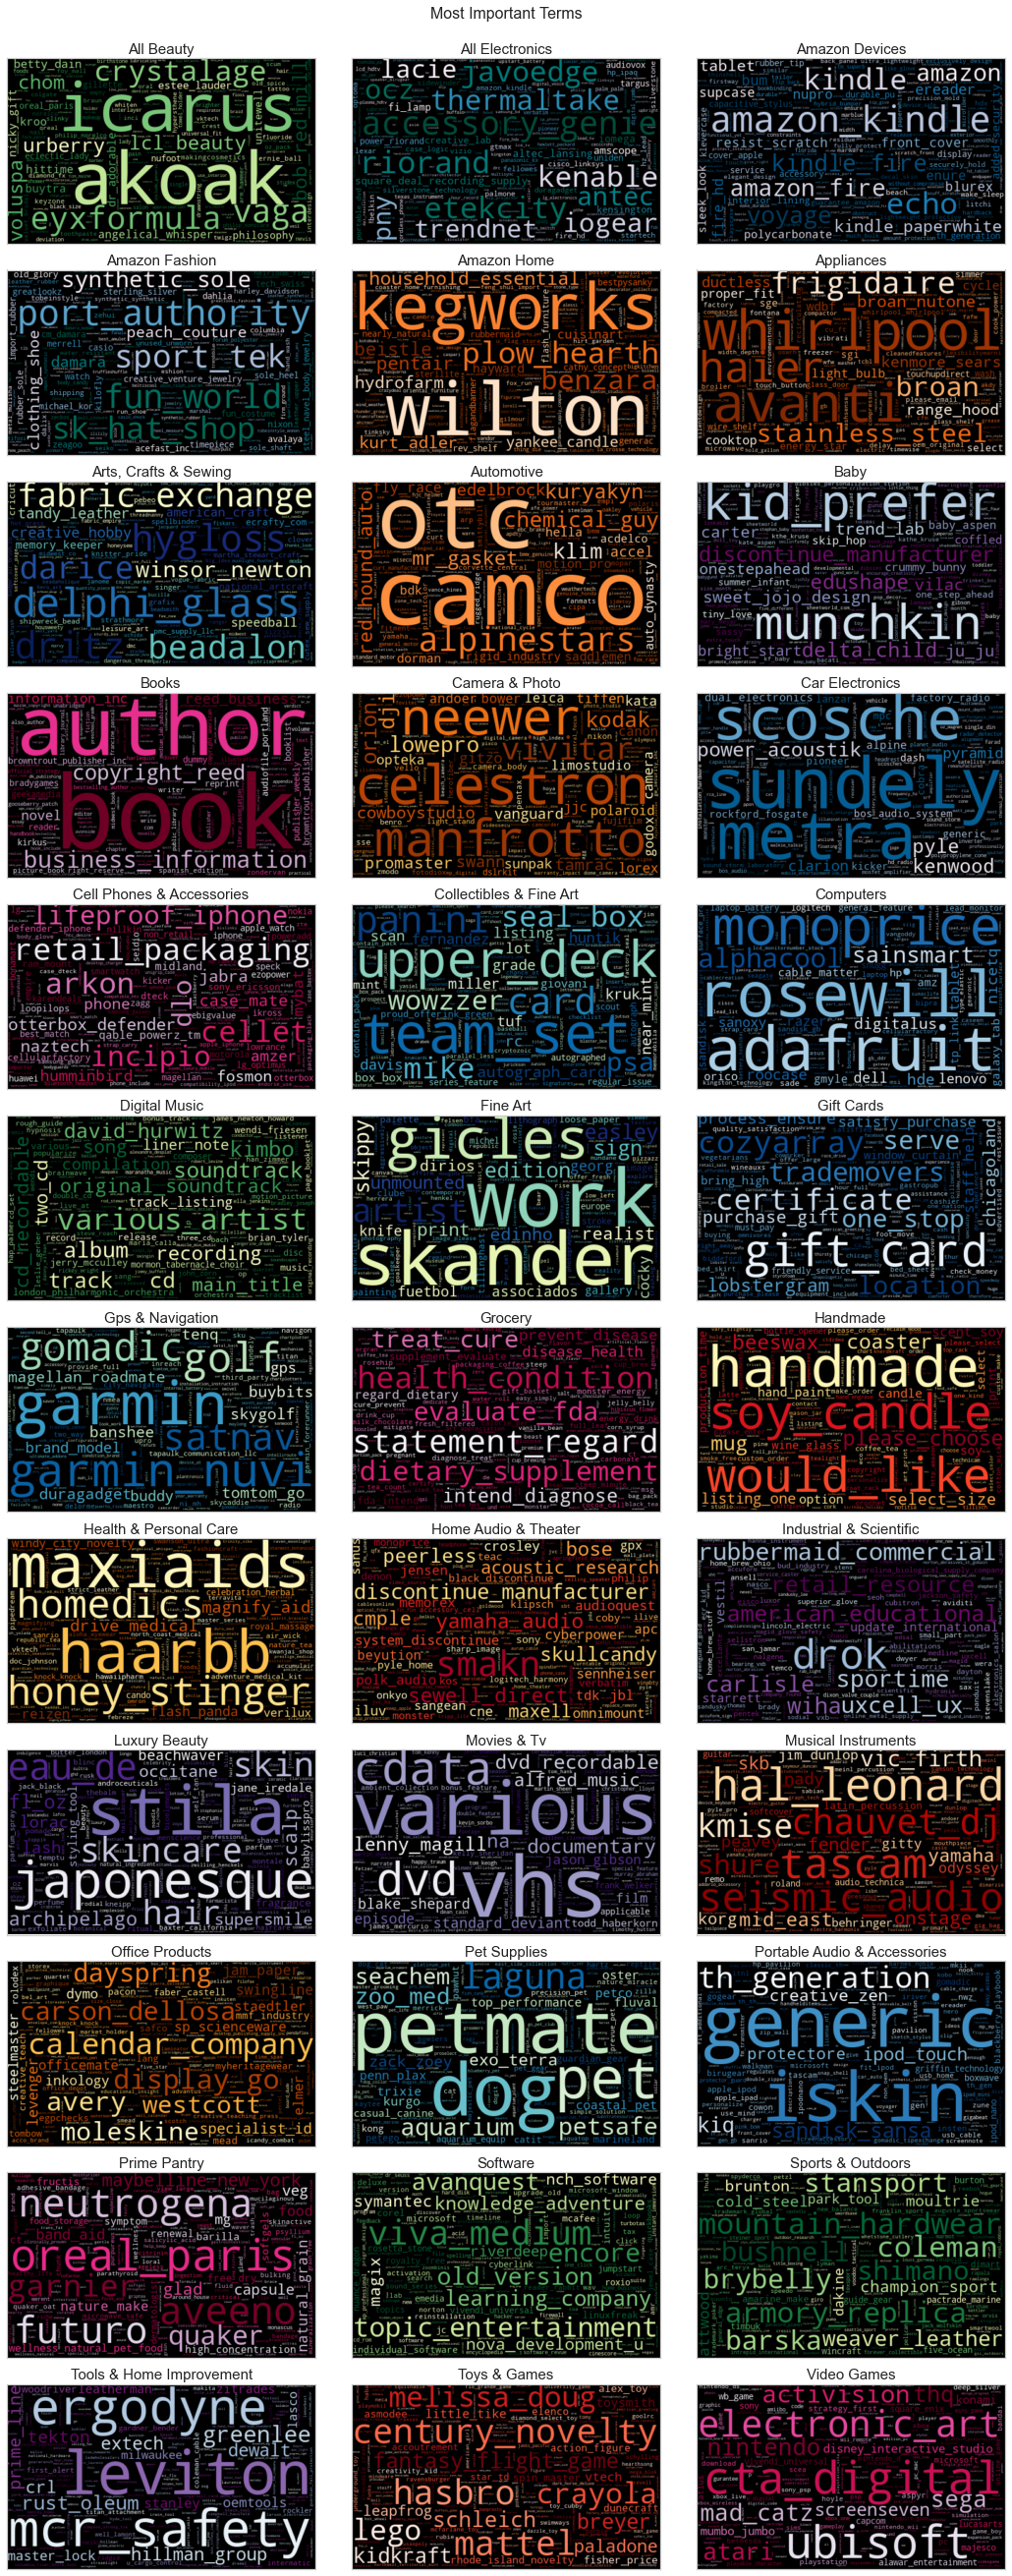

<IPython.core.display.Javascript object>

In [12]:
fig = plotting.wordcloud(
    coef,
    cmap=cmaps,
)
fig.suptitle("Most Important Terms", y=1.01, fontsize=16)
fig.savefig("figures/final_refit_coef.svg", bbox_inches="tight")

In [13]:
ngrams = [tuple(w.split("_")) for w in pipe["vec"].vocabulary_.keys() if "_" in w]
max(map(len, ngrams))

6

<IPython.core.display.Javascript object>

In [14]:
if not isinstance(pipe.steps[0], FreqVectorizer):
    fv = FreqVectorizer.from_sklearn(pipe["vec"])
    pipe.steps[0] = ("vec", fv)
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, lowercase=False, norm='l2',
                                token_pattern='\\S+', use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [15]:
stop_words = set(pd.read_json("canonical_params/stopwords.json", typ="series"))
pprint(stop_words, compact=True)

{'about', 'above', 'address', 'after', 'again', 'against', 'ain', 'all', 'an',
 'and', 'any', 'apo', 'aren', 'as', 'asin', 'be', 'because', 'before', 'below',
 'between', 'both', 'but', 'by', 'can', 'couldn', 'customer', 'didn',
 'dimension', 'do', 'doesn', 'don', 'down', 'during', 'each', 'eligible', 'few',
 'for', 'fpo', 'from', 'further', 'hadn', 'hasn', 'have', 'haven', 'he', 'her',
 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if', 'in', 'inch',
 'into', 'isn', 'it', 'item', 'itself', 'just', 'list', 'll', 'ma', 'me',
 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'not',
 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ounce', 'our',
 'ours', 'ourselves', 'out', 'over', 'own', 'package', 'pound', 'product', 're',
 'review', 'reviewer', 'same', 'shan', 'she', 'ship', 'shipment', 'shipper',
 'should', 'shouldn', 'so', 'some', 'such', 'support', 'than', 'that', 'the',
 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these

<IPython.core.display.Javascript object>

In [21]:
pipe["vec"].set_params(
    lowercase=True,
    stop_words=stop_words,
    strip_accents="ascii",
    strip_html_tags=True,
    strip_punct="_",
    uniq_char_thresh=0.375,
    stemmer="wordnet",
    token_pattern="(?i)\\b[a-z_]{2,16}\\b",
    ngram_range=(1, 6),
)

FreqVectorizer(binary=True, ngram_range=(1, 6), norm='l2', stemmer='wordnet',
               stop_words={'about', 'above', 'address', 'after', 'again',
                           'against', 'ain', 'all', 'an', 'and', 'any', 'apo',
                           'aren', 'as', 'asin', 'be', 'because', 'before',
                           'below', 'between', 'both', 'but', 'by', 'can',
                           'couldn', 'customer', 'didn', 'dimension', 'do',
                           'doesn', ...},
               strip_accents='ascii', strip_html_tags=True, strip_punct='_',
               token_pattern='(?i)\\b[a-z_]{2,16}\\b', uniq_char_thresh=0.375,
               use_idf=True)

<IPython.core.display.Javascript object>

In [22]:
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, ngram_range=(1, 6), norm='l2',
                                stemmer='wordnet',
                                stop_words={'about', 'above', 'address',
                                            'after', 'again', 'against', 'ain',
                                            'all', 'an', 'and', 'any', 'apo',
                                            'aren', 'as', 'asin', 'be',
                                            'because', 'before', 'below',
                                            'between', 'both', 'but', 'by',
                                            'can', 'couldn', 'customer', 'didn',
                                            'dimension', 'do', 'doesn', ...},
                                strip_accents='ascii', strip_html_tags=True,
                                strip_punct='_',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                uniq_ch

<IPython.core.display.Javascript object>

In [23]:
joblib.dump(pipe, "models/final_deploy.joblib", compress=("lz4", 3))

['models/final_deploy.joblib']

<IPython.core.display.Javascript object>